In [1]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression

import torch
import torch.nn as nn
import torch.distributions as dist

import matplotlib.pyplot as plt

## Define a synthetic "task distribution"

The following code will sample random 2d classification problems.

In [2]:
def sample_random_task():
    # Random number of datapoints
    N = np.random.randint(50, 100)
    # Random class assignments
    y = np.random.randint(2, size=(N,))
    # cluster centers
    K = 6
    mu = np.random.randn(K, 2)
    # cluster variances
    C = 0.1 + np.random.rand(K, 2)
    # cluster weights
    w = np.zeros(K)
    w[np.argsort(mu[:,0])[:int(K/2)]] = 1
    # data points
    z = np.zeros(N, dtype=int)
    z[y==0] = np.random.multinomial(1, w / w.sum(), size=((y==0).sum(),)).argmax(-1)
    z[y==1] = np.random.multinomial(1, (1-w) / (1-w).sum(), size=((y==1).sum(),)).argmax(-1)
    X = mu[z] + C[z]*np.random.randn(N, 2)
    theta = np.random.rand()*2*np.pi
    R = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta),  np.cos(theta)]])
    return X @ R.T, y

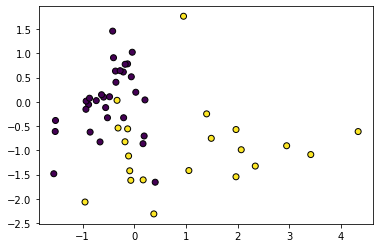

In [3]:
X, y = sample_random_task()
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k');

## Baseline / testing classifier

Logistic regression, with polynomial features.

In [4]:
def features(X):
    return PolynomialFeatures(degree=3).fit_transform(X)

def predict(X, w):
    Phi = features(X)
    return np.array(Phi @ w > 0, dtype=int)

def logistic_prob(w):
    return lambda X: 1/(1 + np.exp(-features(X) @ w))
    

def plot_boundary(X, y, pred):
    h = 0.2
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = pred(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=.8)
    
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
    
    plt.contour(xx, yy, Z, levels=(0.5,), linestyles='dashed');
    
    # Plot the testing points
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    

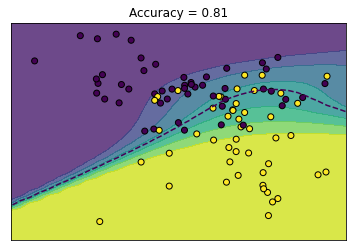

In [5]:
X, y = sample_random_task()
w = LogisticRegression(fit_intercept=False).fit(features(X), y).coef_.squeeze()
plot_boundary(X, y, logistic_prob(w))
plt.title("Accuracy = %0.2f" % (predict(X, w) == y).mean());

## Build a meta-training dataset

In [6]:
# build training dataset
meta_train = []
for _ in range(500):
    X, y = sample_random_task()
    meta_train.append((X, y))

## Define a meta-learner

In [7]:
class PrototypeNetwork(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.f = nn.Sequential(nn.Linear(10, 200), 
                               nn.Softplus(), 
                               nn.Linear(200, 100), 
                               nn.Softplus())
        
    def fit(self, Phi, y):
        f = self.f(Phi)
        self.c0 = f[y==0].mean(0)
        self.c1 = f[y==1].mean(0)
        z = -(torch.stack((self.c0, self.c1)) - f[:,None,:]).pow(2).sum(-1)
        return z[:,1] - torch.logsumexp(z, -1)
        
    def predict(self, Phi):
        f = self.f(Phi)
        z = -(torch.stack((self.c0, self.c1)) - f[:,None,:]).pow(2).sum(-1)
        return (z[:,1] - torch.logsumexp(z, -1)).exp()
    
    def forward(self, X):
        return self.predict(torch.FloatTensor(features(X)))



## Optimize the meta-learner

In [8]:
model = PrototypeNetwork()
opt = torch.optim.Adam(model.parameters())

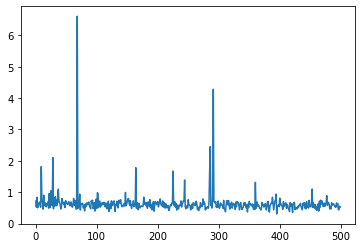

In [9]:
meta_losses = []

# look at each task once
for X, y in meta_train:
    opt.zero_grad()
    Phi = torch.FloatTensor(features(X))
    w_hat = model.fit(Phi, torch.LongTensor(y))

    # Loss is negative Bernoulli log-likelihood
    py = dist.Bernoulli(logits=w_hat)
    loss = -py.log_prob(torch.FloatTensor(y)).mean()
    loss.backward()
    opt.step()
    meta_losses.append(loss.item())

plt.plot(meta_losses);

## Look at performance on new random tasks

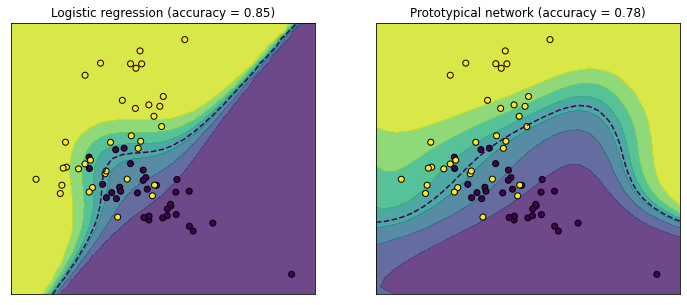

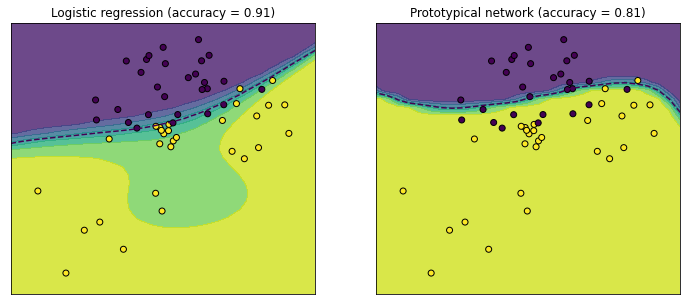

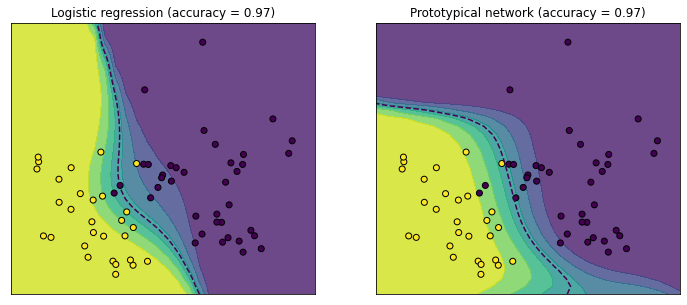

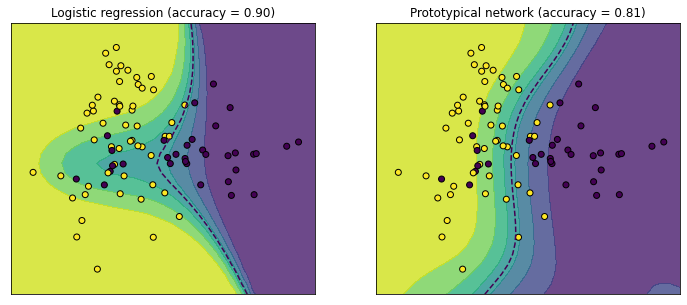

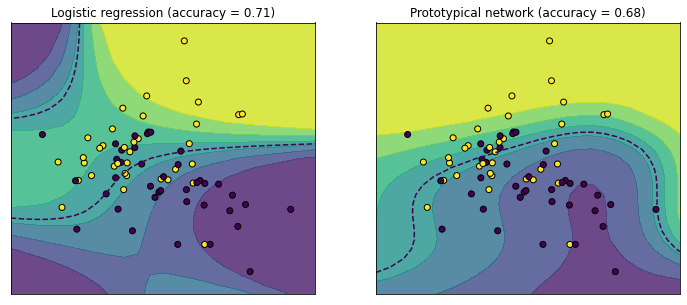

In [10]:
for _ in range(5):
    X, y = sample_random_task()
    plt.figure(figsize=(12,5))
    plt.subplot(121)
    w = LogisticRegression(fit_intercept=False).fit(features(X), y).coef_.squeeze()
    plot_boundary(X, y, logistic_prob(w))
    plt.title("Logistic regression (accuracy = %0.2f)" % (predict(X, w) == y).mean())

    plt.subplot(122)
    with torch.no_grad():
        model.fit(torch.FloatTensor(features(X)), torch.LongTensor(y))
        plot_boundary(X, y, model)
        plt.title("Prototypical network (accuracy = %0.2f)" % ((model(X) > 0.5).numpy() == y).mean())

That works quite well — though the solution is not the same as the logistic regression solution!

# Alternative scheme: Naïve amortized logistic regression

One instantiation of a black-box approach to meta-learning is to exactly estimate the parameters of some model: e.g., learning a mapping from dataset to logistic regression weights.

This is quite naïve, and other approaches will likely do better.

In [11]:
class MetaLogisticRegression(nn.Module):

    def __init__(self):
        super().__init__()
        
        H = 100
        self.embed = nn.Sequential(nn.Linear(10, H), nn.ReLU(), 
                                   nn.Linear(H, H), nn.ReLU())
        self.out = nn.Sequential(nn.Linear(2*H, H),
                                 nn.ReLU(),
                                 nn.Linear(H, 10))

    def forward(self, Phi, y):
        h0 = self.embed(Phi[y==0]).mean(0)
        h1 = self.embed(Phi[y==1]).mean(0)
        h = torch.cat((h0, h1))[None,:]
        return self.out(h).squeeze(0)


In [12]:
meta_logistic = MetaLogisticRegression()
opt = torch.optim.Adam(meta_logistic.parameters())

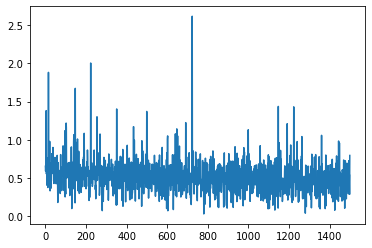

In [13]:
meta_losses = []

# look at each task a few times
for _ in range(3):
    for X, y in meta_train:
        opt.zero_grad()
        Phi = torch.FloatTensor(features(X))
        y = torch.FloatTensor(y)
        # split each task into training and test data
        idx = np.random.permutation(len(y))
        train_cutoff = np.int(0.75*len(y))
        w_hat = meta_logistic(Phi[:train_cutoff], y[:train_cutoff])

        # Loss is negative Bernoulli log-likelihood, on test set
        py = dist.Bernoulli(logits=Phi[train_cutoff:] @ w_hat)
        loss = -py.log_prob(y[train_cutoff:]).mean()
        loss.backward()
        opt.step()
        meta_losses.append(loss.item())

plt.plot(meta_losses);

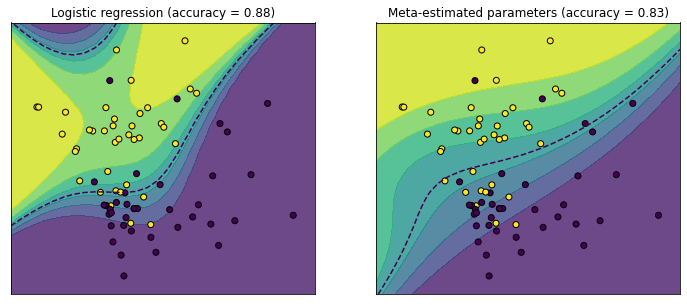

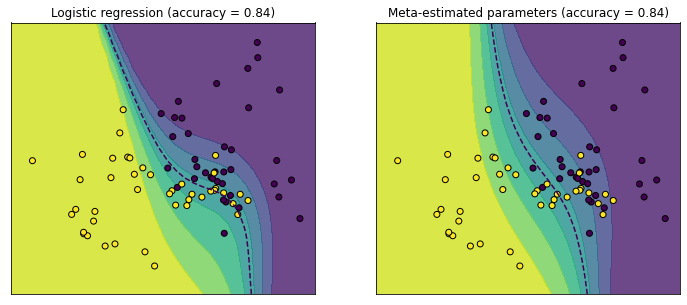

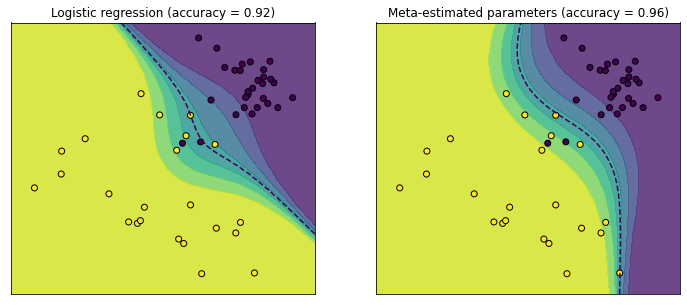

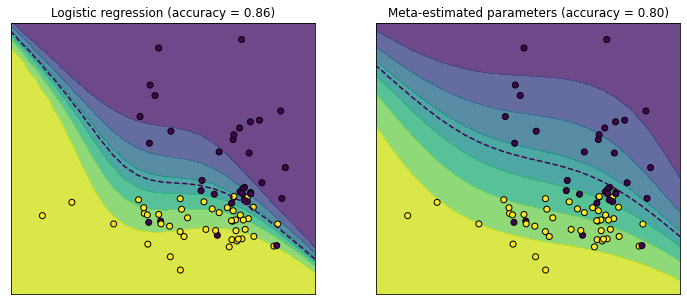

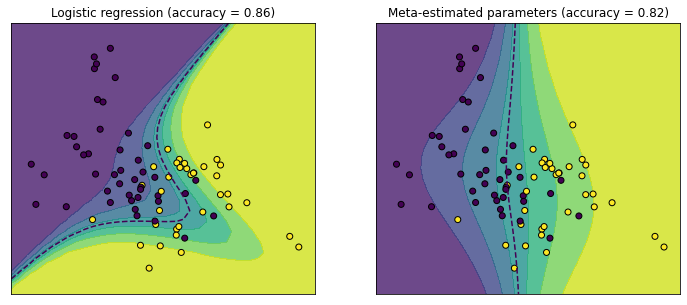

In [14]:
for _ in range(5):
    X, y = sample_random_task()
    plt.figure(figsize=(12,5))
    plt.subplot(121)
    w = LogisticRegression(fit_intercept=False).fit(features(X), y).coef_.squeeze()
    plot_boundary(X, y, logistic_prob(w))
    plt.title("Logistic regression (accuracy = %0.2f)" % (predict(X, w) == y).mean())

    plt.subplot(122)
    with torch.no_grad():
        w = meta_logistic(torch.FloatTensor(features(X)), torch.FloatTensor(y)).numpy()
        plot_boundary(X, y, logistic_prob(w))
        plt.title("Meta-estimated parameters (accuracy = %0.2f)" % (predict(X, w) == y).mean())

